In [1]:
!git clone https://github.com/LiyuanLucasLiu/RAdam.git
!python RAdam/setup.py install

Cloning into 'RAdam'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 298 (delta 9), reused 10 (delta 2), pack-reused 274
Receiving objects: 100% (298/298), 948.24 KiB | 3.89 MiB/s, done.
Resolving deltas: 100% (138/138), done.
running install
running bdist_egg
running egg_info
creating RAdam.egg-info
writing RAdam.egg-info/PKG-INFO
writing dependency_links to RAdam.egg-info/dependency_links.txt
writing requirements to RAdam.egg-info/requires.txt
writing top-level names to RAdam.egg-info/top_level.txt
writing manifest file 'RAdam.egg-info/SOURCES.txt'
reading manifest file 'RAdam.egg-info/SOURCES.txt'
writing manifest file 'RAdam.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying RAdam.egg-info/PKG-

In [0]:
# imports
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from RAdam import radam

import cv2
import matplotlib.image as mpimg
import numpy as np
import csv
import requests
import zipfile
import time
import pandas as pd

In [0]:
# class for download
class DataDownloader:

  def __init__(self, file_id, destination, download = True):
    self.file_id = file_id
    self.destination = destination

    if download:
      self.download_dataset()
      self.extract_zip()

  def download_dataset(self):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response):
        CHUNK_SIZE = 32768

        with open(self.destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : self.file_id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : self.file_id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response) 

  def extract_zip(self):
    if not os.path.exists('input'):
      os.makedirs('input')

    if not os.path.exists('output'):
      os.makedirs('output')

    with zipfile.ZipFile(self.destination, 'r') as zip_ref:
      zip_ref.extractall('./input/')

In [0]:
FILE_ID = '1VaYonsJUovGO1AamMQuC2LN47AZ4pkTm'
DST_LOC = './self_driving_dataset.zip'
DATA_CSV_FILE_PATH = './input/driving_log.csv'
DATA_IMAGES_DIR = './input/IMG'
MODEL_SAVE_PATH = './output/ai_driver_cnn.pth'
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3

SAVE_DIR = './output/'

data_download = DataDownloader(FILE_ID, DST_LOC, True)

In [0]:
# Helper defs

def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    name = image_file.split('/')[-1]
    return mpimg.imread(os.path.join(data_dir, name))

def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :]  # remove the sky and the car front


def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


def choose_image(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle


def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle


def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


def random_shadow(image):
    """
    Generates and adds random shadow
    """
    print(image.shape)
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    # image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

In [0]:
class CustomDataset(data.Dataset):

    def __init__(self, csv_file_path, image_dir, transform = None):
        self.csv_file_path = csv_file_path
        self.image_dir = image_dir
        self.transform = transform

        self.examples = []

        with open(self.csv_file_path) as csvfile:
          reader = csv.reader(csvfile)
          next(reader, None)
          for line in reader:
              self.examples.append(line)


    def __getitem__(self, index):
        example = self.examples[index]
        center, left, right = example[0], example[1], example[2]
        steering_angle = float(example[3])

        if np.random.rand() < 0.6:
            image, steering_angle = augument(self.image_dir, center, left, right, steering_angle)
        else:
            image = load_image(self.image_dir, center) 
    
        image = preprocess(image)
        
        if self.transform is not None:
            image = self.transform(image)
           
        return image, steering_angle

    def __len__(self):
        return len(self.examples)

In [0]:
batch_size = 128
num_epochs = 40

validation_split = 0.25
shuffle_dataset = True
random_seed = 42
num_workers = 4

In [9]:
print("Initializing Datasets and Dataloaders...")

# Creating data indices for training and validation splits:
#Create a dataset object
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 127.5) - 1.0)])

dataset = CustomDataset(DATA_CSV_FILE_PATH, DATA_IMAGES_DIR, transformations)
dataset_size = len(dataset)
# dataset_size = 3000
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=valid_sampler, num_workers=num_workers)


data_loader_dict = {
    'train': train_loader,
    'val': validation_loader 
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [0]:
class DriverNet(nn.Module):

  def __init__(self):
        super(DriverNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Dropout(p=0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64*1*18, out_features=100),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=100, out_features=64),
            nn.ELU(),
            nn.Linear(in_features=64, out_features=10),
            nn.ELU(),
            nn.Linear(in_features=10, out_features=1)
        )
        

  def forward(self, input):
      input = input.view(input.size(0), 3, 66, 200)
      output = self.conv_layers(input)
      output = output.view(output.size(0), -1)
      output = self.linear_layers(output)
      return output

In [11]:
model_ft = DriverNet()

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")

for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = radam.RAdam(params_to_update)
# optimizer_ft = optim.SGD(params_to_update, lr = 0.00008)
# optimizer_ft = optim.Adam(params_to_update, lr = 0.0001)

Params to learn:
	 conv_layers.0.weight
	 conv_layers.0.bias
	 conv_layers.2.weight
	 conv_layers.2.bias
	 conv_layers.4.weight
	 conv_layers.4.bias
	 conv_layers.6.weight
	 conv_layers.6.bias
	 conv_layers.8.weight
	 conv_layers.8.bias
	 linear_layers.0.weight
	 linear_layers.0.bias
	 linear_layers.3.weight
	 linear_layers.3.bias
	 linear_layers.5.weight
	 linear_layers.5.bias
	 linear_layers.7.weight
	 linear_layers.7.bias


In [0]:
def toDevice(data, device):
  
  return data.float().to(device)

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    epoch_number, train_losses, val_losses,  = [], [], []
    best_loss = 10000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epoch_number.append(epoch)            
        # Each epoch has a training and validation phase
        # Training loop
        train_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for inputs, labels in dataloaders['train']:
          inputs = toDevice(inputs, device)
          labels = toDevice(labels, device)

          optimizer.zero_grad()
          # Generate predictions
          out = model(inputs)
          # Calculate loss
          loss = criterion(out, labels.unsqueeze(1))
          # Backpropagation
          loss.backward()
          # Update model parameters
          optimizer.step()

          train_loss += loss.item()

        # Validation 
        model.eval()
        with torch.no_grad():
          for inputs, labels in dataloaders['val']:
            inputs = toDevice(inputs, device)
            labels = toDevice(labels, device)
            # Generate predictions 
            out = model(inputs)
            # Calculate loss
            loss = criterion(out, labels.unsqueeze(1))
            
            val_loss += loss.item()

        # Average validation loss
        train_loss = train_loss / len(dataloaders['train'])
        val_loss = val_loss / len(dataloaders['val'])

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print('Train Loss: {:.4f}'.format(train_loss))
        print('Val Loss: {:.4f}'.format(val_loss))

        # If the validation loss is at a minimum
        if val_loss < best_loss:
          # Save the model
          torch.save(model, MODEL_SAVE_PATH)
          best_loss = val_loss

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lead val Loss: {:4f}'.format(best_loss))

    #creating dataframe and record all the losses and accuracies at each epoch
    log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
    log_frame["Epoch"] = epoch_number
    log_frame["Train Loss"] = train_losses
    log_frame["Test Loss"] = val_losses
    log_frame.to_csv(os.path.join(SAVE_DIR, "log2.csv"), index = False)

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model

In [0]:
criterion = nn.MSELoss()

# Train and evaluate
model_ft = train_model(model_ft, data_loader_dict, criterion, optimizer_ft, num_epochs=num_epochs)

In [0]:
frame = pd.read_csv(os.path.join(SAVE_DIR, "log.csv"))
frame

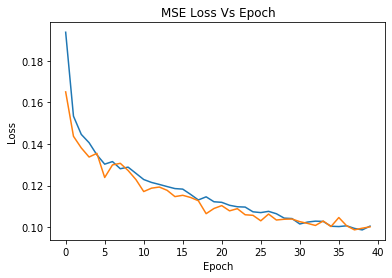

In [17]:
from matplotlib import pyplot as plt
from matplotlib import style

from numpy import genfromtxt

data = genfromtxt(os.path.join(SAVE_DIR, "log2.csv"),delimiter=',', names=['Epoch', 'Train Loss', 'Test Loss'])
epoch_list = []
train_loss_list = []
test_loss_list = []
for row in data:
  if not np.isnan(row[0]):
    epoch_list.append(row[0])
    train_loss_list.append(row[1])
    test_loss_list.append(row[2])
  

plt.plot(epoch_list, train_loss_list, label = "Training Loss")
plt.plot(epoch_list, test_loss_list, label = "Testing Loss")

plt.title('MSE Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()